# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [1]:
%pylab inline
import cPickle, gzip

# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f)

mnist_dim = (28, 28)
print "MNIST data loaded;", \
    " number of samples:", len(mnist_labels), \
    '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

Populating the interactive namespace from numpy and matplotlib
MNIST data loaded;  number of samples: 5000 ; number of pixels per sample: 28 x 28


## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

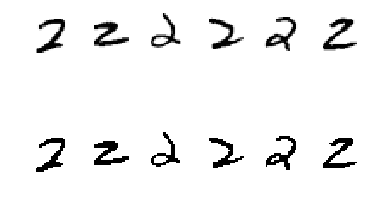

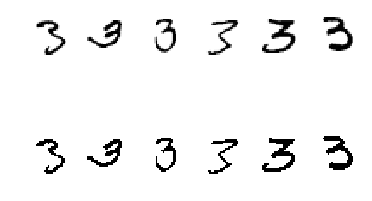

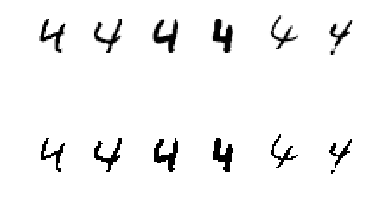

In [2]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1) # changed i to i+1 to prevent indexing error!
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
zipped = zip(mnist_images[0:100], mnist_labels[0:100])
# select images of digits 2, 3 and 4 
twos = np.array([im for im, num in zipped if num == 2])
threes = np.array([im for im, num in zipped if num == 3])
fours = np.array([im for im, num in zipped if num == 4])

# plot a few original images and their binarized versions stacked vertically
plot_digits(np.vstack((twos[0:6], twos[0:6] > 0.5)), numcols=6)
print('\n')
plot_digits(np.vstack((threes[0:6], threes[0:6] > 0.5)), numcols=6)
print('\n')
plot_digits(np.vstack((fours[0:6], fours[0:6] > 0.5)), numcols=6)

### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [5]:
def EM(batch, K, max_iter):
    D = batch[0].shape[0]
    N = len(batch)
    
    pi = np.array([1.0/K]*K) # initialize uniformly
    draws = np.random.uniform(0.25, 0.75, size=(K, D))
    mu = draws * np.sum(draws, axis=1, keepdims=True)**-1

    for i in range(max_iter):
        print 'Iteration {0}/{1}'.format(i+1, max_iter)
              
        # E-step
        p_tilde = np.array([[pi[k]*np.prod([mu[k][i]**batch[n][i] * (1-mu[k][i])**(1-batch[n][i]) 
                                    for i in range(D)]) 
                                        for k in range(K)] 
                                           for n in range(N)])
        norm = np.sum(p_tilde, axis=1, keepdims=True)
        # to remedy division by zero: else we get nan
        posterior = np.divide(p_tilde, norm, out=np.zeros_like(p_tilde), where=norm!=0) 
        
        # M-step
        pi = np.sum(posterior, axis=0) * np.sum(posterior)**-1
        
        mu_tilde = np.array([np.sum([batch[n] * posterior[n][k] for n in range(N)], axis=0) for k in range(K)])
        norm = np.sum(posterior, axis=0, keepdims=True).T
        mu = mu_tilde * norm**-1
        
    return pi, mu

### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

In [4]:
zipped = zip(mnist_images, mnist_labels)
# select images of digits 2, 3 and 4 
twos = [im for im, num in zipped if num == 2]
threes = [im for im, num in zipped if num == 3]
fours = [im for im, num in zipped if num == 4]

print(len(twos), len(threes), len(fours))

batch = np.array(twos + threes + fours) > 0.5

(512, 459, 498)


In [5]:
K = 3
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


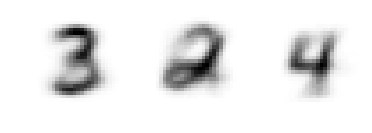

[ 0.45686946  0.2320402   0.31109035]


In [6]:
plot_digits(mu, numcols=3)
print(pi)

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

#### 1.3.2

In [6]:
def predict(im, mu, pi):
    distances = list()
    for m in mu:
        dist = np.linalg.norm(im - m)
        distances.append(dist)
    return np.argmin(distances)
        
def classify(batch, mu, pi, labels):
    """
    :labels: the manually determined class of each cluster in order
    """
    wrong = list()
    right = list()
    for im, num in batch:
        pred = predict(im, mu, pi)
        if not labels[pred]==num:
            wrong.append((im, labels[pred]))
        else:
            right.append((im, labels[pred]))
    return right, wrong

In [7]:
zipped = zip(mnist_images, mnist_labels)

twos = [(im,num) for im, num in zipped if num == 2]
threes = [(im,num) for im, num in zipped if num == 3]
fours = [(im,num) for im, num in zipped if num == 4]

concat = twos + threes + fours
np.random.shuffle(concat)

test = np.array(concat)

In [8]:
right, wrong = classify(test, mu, pi, labels=[2,4,3])

print('Correct total: {0}/{1} = {2}'.format(len(right), len(wrong)+len(right), len(right)/float(len(wrong)+len(right))))

wrong_twos = [pred for im, pred in wrong if pred==2]
print('Icorrect 2s: {0}/{1} = {2}'.format(len(wrong_twos), len(twos), len(wrong_twos)/float(len(twos))))

wrong_threes = [pred for im, pred in wrong if pred==3]
print('Icorrect 3s: {0}/{1} = {2}'.format(len(wrong_threes), len(threes), len(wrong_threes)/float(len(threes))))

wrong_fours = [pred for im, pred in wrong if pred==4]
print('Icorrect 4s: {0}/{1} = {2}'.format(len(wrong_fours), len(fours), len(wrong_fours)/float(len(fours))))

NameError: name 'mu' is not defined

In [9]:
ims = np.array([im for im, pred in wrong[0:8]])
preds = [pred for im, pred in wrong[0:8]]

print('Some of the misclassified images:')
plot_digits(ims, numcols=8)
print(preds)

NameError: name 'wrong' is not defined

#### 1.3.1

In [234]:
batch = np.array(twos[0:100] + threes[0:100] + fours[0:100]) > 0.5
K = 4
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


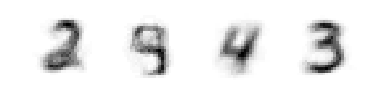

[ 0.18045967  0.13600229  0.41553956  0.26799848]


In [236]:
plot_digits(mu, numcols=4)
print(pi)

In [237]:
batch = np.array(twos[0:100] + threes[0:100] + fours[0:100]) > 0.5
K = 2
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


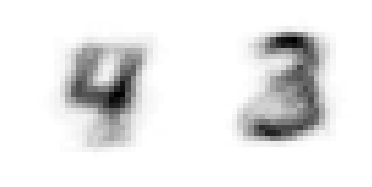

[ 0.51601447  0.48398553]


In [239]:
plot_digits(mu, numcols=2)
print(pi)

In [240]:
batch = np.array(twos[0:100] + threes[0:100] + fours[0:100]) > 0.5
K = 1
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


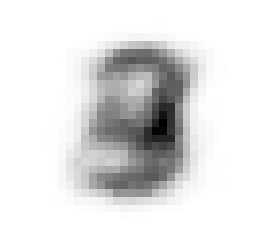

[ 1.]


In [243]:
plot_digits(mu, numcols=1)
print(pi)

### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

_YOUR ANSWER HERE_



## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


_YOUR ANSWER HERE_

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence. Run the 

In [4]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## COMMENT N_samples = 5000, X_dim = 784
N_samples, X_dim = mnist_images.shape 
## COMMENT minibatch size
mb_size = 64
## COMMENT dimension of latent space Z
Z_dim = 100 
## COMMENT dimension of hidden layer
h_dim = 128 
## COMMENT learning rate for gradient based optimizer
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## COMMENT encoder parameters for mapping X -> Z
Wxh = init_weight(size=[X_dim, h_dim]) # matrix taking x to hidden layer h
bxh = Variable(torch.zeros(h_dim), requires_grad=True) # bias vector for transformation Wxh
Whz_mu = init_weight(size=[h_dim, Z_dim]) # matrix taking hidden layer h to mu-part of z
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim]) # matrix taking hidden layer h to sigma-part of z
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## COMMENT
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1)) # h = relu(X*Wxh + bxh)
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1) # z_var = log(sigma^2) => sigma = exp(z_var / 2) 
                                                         # (see Kingma p.11)
    return z_mu, z_var

## COMMENT
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps # sigma = exp(z_var / 2) (see Kingma p.11)

## COMMENT decoder parameters for mapping X -> Z
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## COMMENT
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## COMMENT
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)

losses = list()
def run(num_iter):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## COMMENT
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)
        X_sample = P(z)

        ## COMMENT
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## COMMENT
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        losses.append(loss.data.numpy()[0])
        
        ## COMMENT
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()

In [5]:
run(2000)

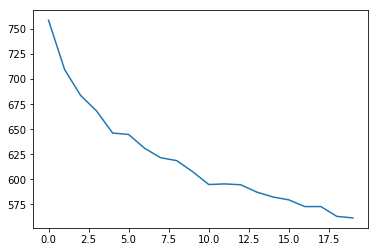

In [6]:
ls = [losses[i] for i in range(len(losses))]
plt.plot(range(len(ls)), ls)

In [8]:
M = mnist_images[0:64]
X = Variable(torch.from_numpy(M))
z_mu, z_var = Q(X)

# samples = [sample_z(z_mu, z_var) for i in range(5)]
# decoded = [P(z).data.numpy() for z in samples]
# sample = sample_z(z_mu, z_var)
# decode = P(sample)

# sum a number of samples
sample = sample_z(z_mu, z_var)
for i in range(2):
    sample += sample_z(z_mu, z_var)
print(sample)
decode = P(sample).data.numpy()
print(type(decode))

Variable containing:
-4.7404 -2.6276 -0.0937  ...  -0.9761  1.1661 -2.0218
-1.4854 -1.6946 -2.5054  ...  -1.5817  1.4649  0.7109
-2.1982  0.2306  0.5465  ...  -2.0534  1.4213  2.9660
          ...             ⋱             ...          
-2.2826  0.6134 -0.9702  ...  -3.8282 -0.5805 -1.2697
 0.7076  0.1448 -1.3063  ...  -1.2797  1.6909 -3.1056
-0.3844 -2.0154 -1.0436  ...   0.1119  3.6968  0.1860
[torch.FloatTensor of size 64x100]

<type 'numpy.ndarray'>


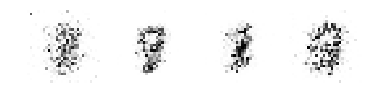

In [293]:
plot_digits(decode[10:14], numcols=4)
plot_digits(M[10:14], numcols=4)

[[ 0.10779276  0.08198871  0.08325242 ...,  0.25120956  0.03498765
   0.18177065]
 [ 0.09408575  0.25527191  0.13605434 ...,  0.24296255  0.06559939
   0.27876624]
 [ 0.1117233   0.28892133  0.16215436 ...,  0.46430549  0.13596153
   0.35346961]
 ..., 
 [ 0.03096885  0.04828339  0.07591365 ...,  0.16823325  0.00873583
   0.05650373]
 [ 0.00199923  0.02432006  0.03815424 ...,  0.0048436   0.00264708
   0.04341152]
 [ 0.05720624  0.01813145  0.18859541 ...,  0.04118099  0.01403281  0.19211   ]]


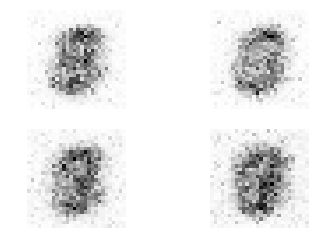

In [200]:
d = reduce(np.add, decoded)
print(d)
plot_digits(d[0:4], numcols=2)

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?

In [34]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## COMMENT N_samples = 5000, X_dim = 784
N_samples, X_dim = mnist_images.shape 
## COMMENT minibatch size
mb_size = 64
## COMMENT dimension of latent space Z
Z_dim = 2 
## COMMENT dimension of hidden layer
h_dim = 128 
## COMMENT learning rate for gradient based optimizer
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## COMMENT encoder parameters for mapping X -> Z
Wxh = init_weight(size=[X_dim, h_dim]) # matrix taking x to hidden layer h
bxh = Variable(torch.zeros(h_dim), requires_grad=True) # bias vector for transformation Wxh
Whz_mu = init_weight(size=[h_dim, Z_dim]) # matrix taking hidden layer h to mu-part of z
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim]) # matrix taking hidden layer h to sigma-part of z
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## COMMENT
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1)) # h = relu(X*Wxh + bxh)
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1) # z_var = log(sigma^2) => sigma = exp(z_var / 2) 
                                                         # (see Kingma p.11)
    return z_mu, z_var

## COMMENT
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps # sigma = exp(z_var / 2) (see Kingma p.11)

## COMMENT decoder parameters for mapping X -> Z
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## COMMENT
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## COMMENT
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)

losses = list()
def run(num_iter):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## COMMENT
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)
        X_sample = P(z)

        ## COMMENT
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## COMMENT
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        losses.append(loss.data.numpy()[0])
        
        ## COMMENT
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()

In [35]:
run(2000)

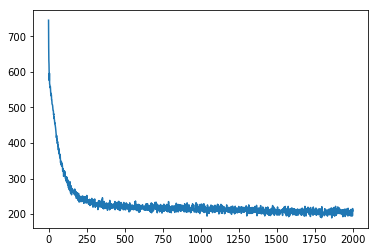

In [40]:
plt.plot(range(len(losses)), losses)

In [44]:
mu = Variable(torch.FloatTensor([[1,1]]*64))
var = Variable(torch.FloatTensor([[1,1]]*64))

grid = np.array([
    [P(sample_z(Variable(torch.FloatTensor([[x,y]]*64)), Variable(torch.FloatTensor([[x,y]]*64)))).data.numpy()[1] \
          for x in np.linspace(-1,1,10)] for y in np.linspace(-1,1,10)])

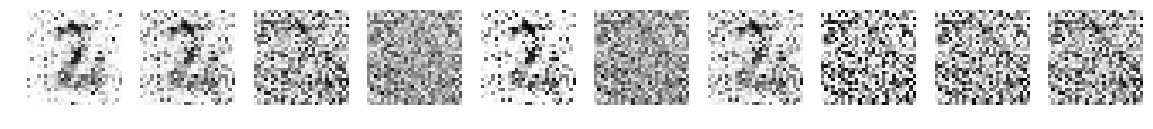

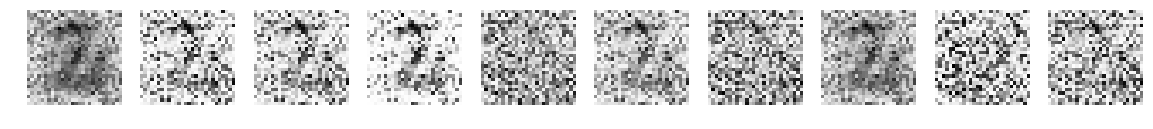

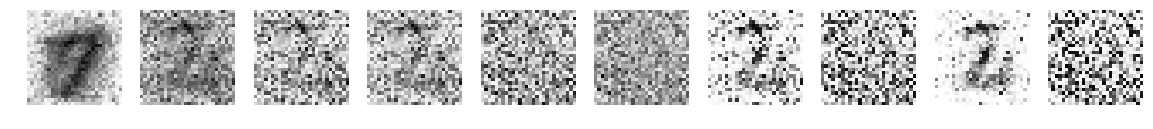

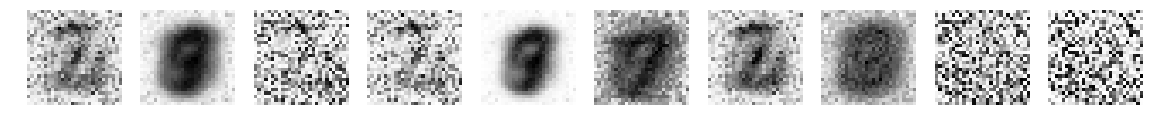

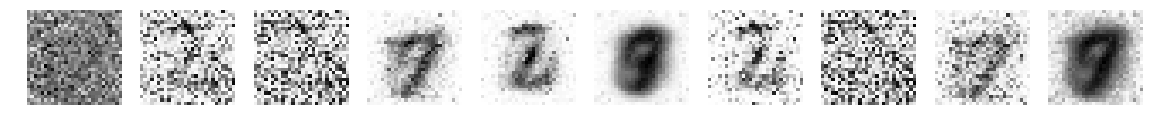

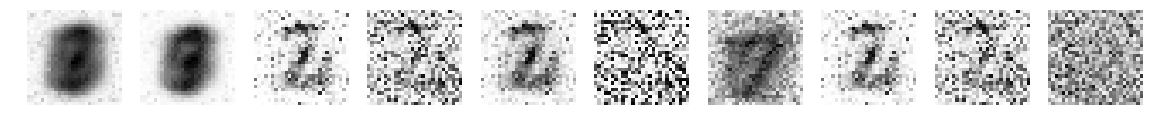

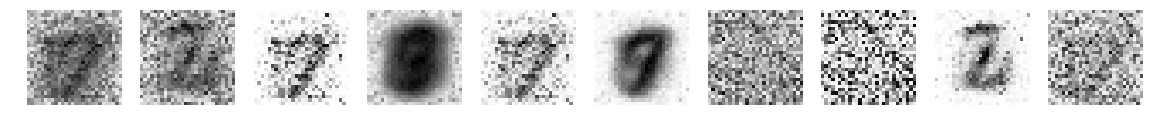

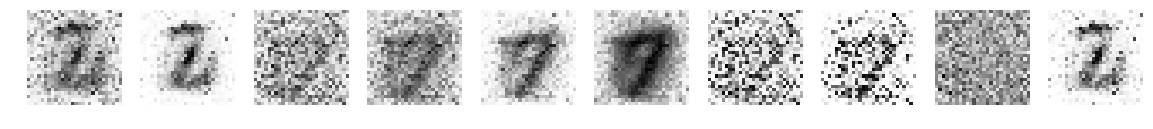

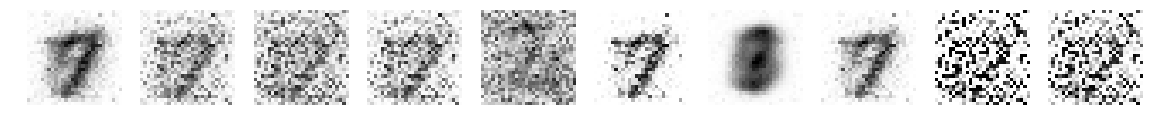

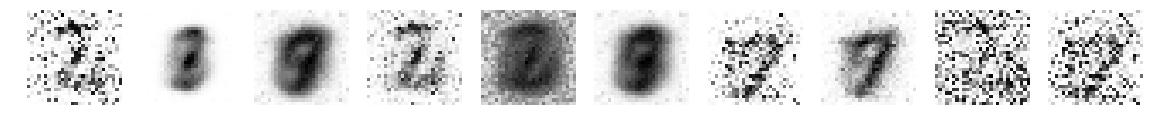

In [45]:
for row in grid:
    plt.figure(figsize=(20, 20))
    plot_digits(row, numcols=10)